In [4]:
# ==================================
# 1. Setup
# ==================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load datast
df = pd.read_csv("../data/Telco-Customer-Churn.csv")

# Quick look at the data
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Prep data

/tmp/ipykernel_29746/2107842928.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


Feature matrix shape: (7043, 30)


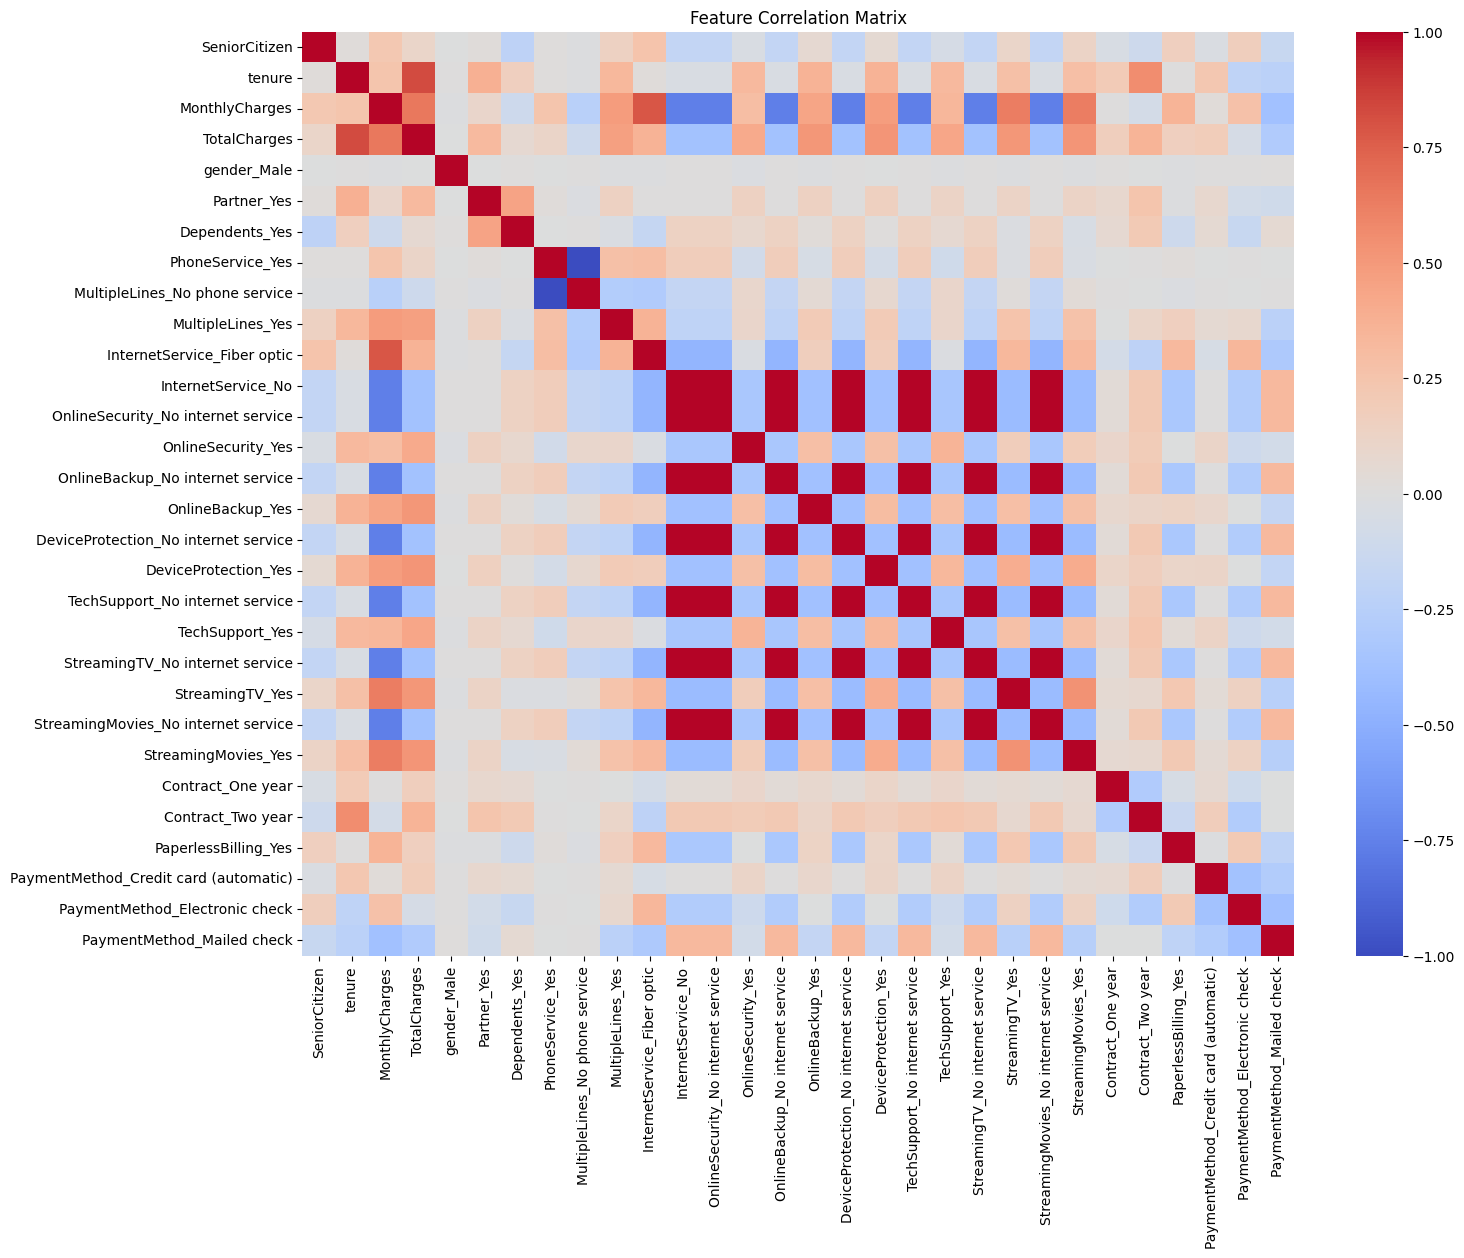

Dropped columns due to high correlation: ['MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']
New feature matrix shape: (7043, 23)


In [5]:
# Drop ID + Churn (no labels for clustering)
df = df.drop(columns=["customerID", "Churn"])

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

print("Feature matrix shape:", X_scaled.shape)

# TODO:
# - Inspect correlations between features
corr_matrix = df_encoded.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Matrix")
plt.show()


# Drop highly correlated columns (correlation > 0.95)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.95)]
df_encoded = df_encoded.drop(columns=to_drop)
print("Dropped columns due to high correlation:", to_drop)

# Re-scale after dropping columns
X_scaled = scaler.fit_transform(df_encoded)
print("New feature matrix shape:", X_scaled.shape)

### Why Drop Highly Correlated Features?

Highly correlated features (multicollinearity) can negatively impact clustering and other machine learning algorithms by:
- **Redundancy:** Multiple features provide the same information, making the model unnecessarily complex.
- **Distorted Distance Metrics:** Algorithms like KMeans rely on distance calculations; redundant features can bias these distances.
- **Reduced Interpretability:** It becomes harder to interpret the importance of individual features.

By removing highly correlated features, we simplify the feature space, reduce noise, and improve clustering performance.

---

### How Do We Identify High Correlation?

1. **Compute Correlation Matrix:**  
    Calculate the pairwise correlation coefficients between all features (e.g., using `df_encoded.corr()`).

2. **Set a Threshold:**  
    Define a threshold for "high" correlation (commonly |correlation| > 0.95).

3. **Find Pairs Above Threshold:**  
    Identify feature pairs where the absolute correlation exceeds the threshold.

4. **Drop One Feature from Each Pair:**  
    Remove one feature from each highly correlated pair to reduce redundancy.

In this notebook, we used the upper triangle of the correlation matrix to avoid duplicate checks and dropped columns with correlation > 0.95.

In [ ]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.3)
plt.title("PCA Projection of Customers")
plt.show()


print("Explained variance ratio:", pca.explained_variance_ratio_)

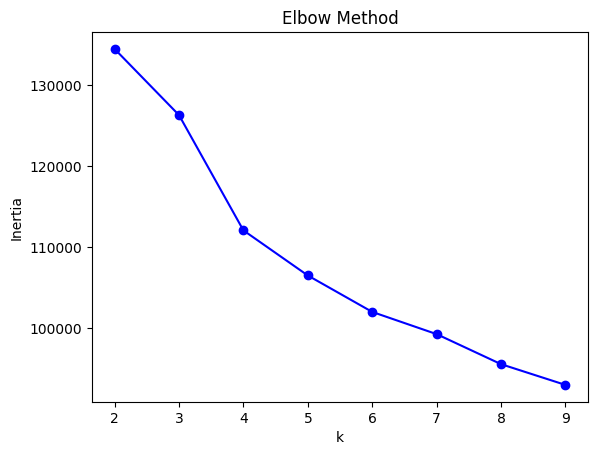

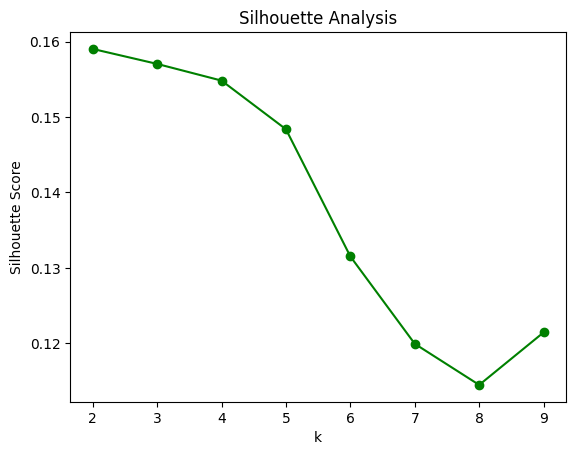

Chosen k: 1


In [ ]:
# ==================================
# 4. KMeans Clustering
# ==================================
# Try different values of k
inertia = []
sil_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Elbow plot
plt.plot(K, inertia, "bo-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Silhouette scores
plt.plot(K, sil_scores, "go-")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()



In [26]:

best_k = 3 
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_scaled)

# Attach cluster labels
df_clusters = df.copy()
df_clusters["Cluster"] = clusters

df_clusters["Cluster"].value_counts()

Cluster
1    3280
2    3081
0     682
Name: count, dtype: int64

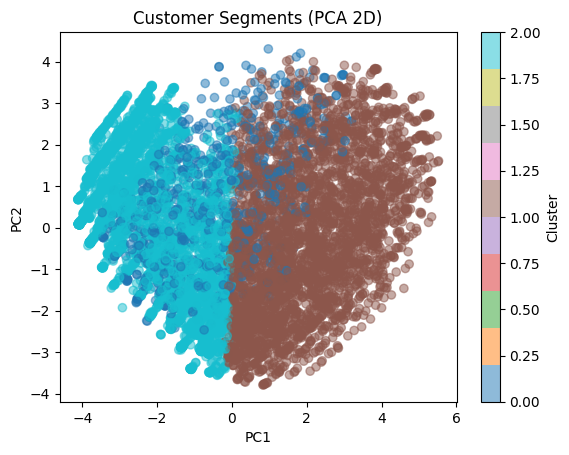

In [ ]:
# ==================================
# 6. Cluster Visualization
# ==================================
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", alpha=0.5)
plt.title("Customer Segments (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()



#### What does this customer segment plot show?

The scatter plot above visualizes all customers projected into two principal components (PC1 and PC2) using PCA, with each point colored by its assigned cluster label from KMeans. Each color represents a different customer segment discovered by the clustering algorithm.

**Interpretation:**
- **Cluster Separation:** The plot shows how well the clusters are separated in the reduced 2D space. Distinct groupings suggest meaningful segmentation.
- **Customer Segments:** Each cluster groups customers with similar characteristics across many features (e.g., tenure, charges, contract type).
- **Business Insight:** By examining the cluster summary statistics (see next section), you can interpret what defines each segment, such as "long-tenure, high-value customers" or "new, low-spending customers."

This visualization helps you quickly assess the effectiveness of clustering and provides an intuitive overview of the customer segments in your dataset.

In [31]:
# ==================================
# 7. Interpret Clusters
# ==================================
# Only aggregate numeric columns for mean
numeric_cols = df_clusters.select_dtypes(include=[np.number]).columns
cluster_summary = df_clusters.groupby("Cluster")[numeric_cols].mean()
print(cluster_summary)

# TODO:
# - Compare cluster profiles (tenure, MonthlyCharges, TotalCharges)
# - Look at categorical breakdowns (e.g., Contract type per cluster)
# - Give descriptive labels like "High-Value Long Tenure" vs "New Low Spenders"


         SeniorCitizen     tenure  MonthlyCharges  TotalCharges  Cluster
Cluster                                                                 
0             0.152493  31.737537       42.028592   1500.131818      0.0
1             0.233537  42.980183       90.483643   3928.347210      1.0
2             0.088283  21.217137       42.410500    702.198044      2.0


In [ ]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering

# DBSCAN
dbscan = DBSCAN(eps=2, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)
print("DBSCAN clusters:", np.unique(dbscan_labels), "Counts:", np.bincount(dbscan_labels + 1))  # +1 to handle -1 (noise)

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=best_k)
agg_labels = agg.fit_predict(X_scaled)
print("Agglomerative clusters:", np.unique(agg_labels), "Counts:", np.bincount(agg_labels))




# - Use more advanced visualization: t-SNE or UMAP
# - 
# - Write a short business insight summary:
#   "We identified 4 customer segments that differ by contract type,
#    spending patterns, and tenure. These segments could guide retention strategies."


DBSCAN clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53] Counts: [6033   23   17   24   80   26   16   11   13   27   13   14   19   21
   66   16   24   41   29   10   26   11   19   12   23   30   11   10
   20   12   16   23   29   10   31   12   11   12   14   13   13   10
   13   12   10   11   10   11   10   19   11   13   12   10   10]
Agglomerative clusters: [0 1 2] Counts: [3792 1499 1752]


### How to Interpret a Cluster

A **cluster** in the context of customer segmentation is a group of customers who share similar characteristics across multiple features. Clustering algorithms, such as KMeans, group data points so that those within the same cluster are more similar to each other than to those in other clusters.

#### Key Points for Cluster Interpretation

- **Feature Averages:**  
    Examine the mean values of important features (e.g., tenure, MonthlyCharges, TotalCharges) within each cluster to understand typical customer profiles.

- **Distinctive Traits:**  
    Identify what makes each cluster unique. For example, one cluster may have high tenure and low churn, while another may have high monthly charges and higher churn risk.

- **Business Relevance:**  
    Assign descriptive labels to clusters, such as "Long-term Loyal Customers" or "New High-Spending Customers," to make insights actionable for marketing or retention strategies.

#### Example

Suppose Cluster 1 has:
- High average tenure
- Low average MonthlyCharges
- Low churn rate

**Interpretation:**  
Cluster 1 likely represents long-term, low-spending, and loyal customers. This group may respond well to loyalty rewards but may not be as profitable as high-spending segments.

---

By analyzing the summary statistics and categorical breakdowns for each cluster, you can tailor business actions to the needs and behaviors of different customer segments.

Churn      No  Yes
Cluster           
0         512  170
1        2343  937
2        2319  762


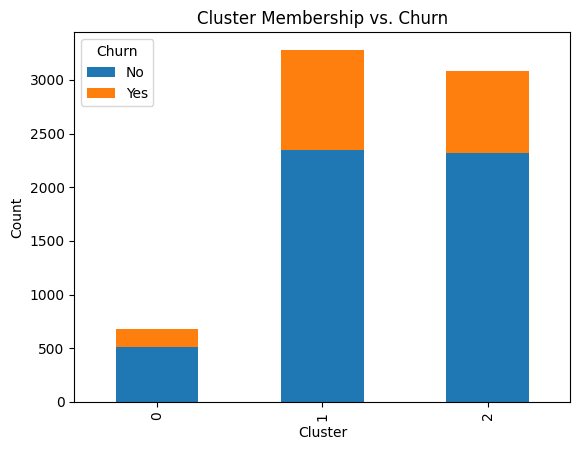

In [35]:
# Cross-check cluster membership against Churn label
# (Churn label was dropped from df, but still present in the original CSV)
# Reload Churn column for comparison
churn_labels = pd.read_csv("../data/Telco-Customer-Churn.csv")["Churn"]

# Compare cluster vs. churn
ct = pd.crosstab(df_clusters["Cluster"], churn_labels)
print(ct)
ct.plot(kind="bar", stacked=True)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Membership vs. Churn")
plt.show()